## Imaginary Time Evolution
In analogy to the real-time evolution under some Hamiltonian $H$ for time $t$, one can define imaginary-time evolution by substituting $t \to -i\tau$.

While most common applications of PauliPropagation.jl work in the Heisenberg picture (evolving observables), imaginary-time evolution is typically defined on quantum states (the Schrödinger picture).

The unnormalized imaginary time evolution of a quantum state $\rho$ to an inverse temperature $\beta$ is given by the similarity transform:
$$\rho(\beta) \propto e^{-\beta H} = e^{-\beta/2 H} \rho(0) e^{-\beta/2 H}$$

Similar to real time, we decompose the Hamiltonian via a Trotter approximation into a product of several _imaginary Pauli rotations_. If $\tau$ is small enough, and if we apply those rotations iteratively $N$ times, we can approximate the thermal state.

In [1]:
using PauliPropagation

In [2]:
# an example imaginary time rotation
gate = ImaginaryPauliRotation([:X, :Y], [1, 3])

ImaginaryPauliRotation([:X, :Y], [1, 3])

But wait, aren't quantum states dense in the Pauli basis? Why do we even work in the Heisenberg picture with observables if we can do this? 

The resolution lies in the distinction between _pure states_ and _mixed states_, and the concept of _temperature_. It is true that pure states are inefficient to represent in the Pauli basis beyond low numbers of qubits $n$, requiring at least $2^n$ Pauli strings. 

However, mixed states can be sparse in the Pauli basis. The extreme example is the _maximally mixed state_ $\rho \propto I$. This is also sometimes called the _infinite temperature state_ ($\beta=0$). It consists of exactly one Pauli string: the identity Pauli string. This implies we can efficiently apply imaginary time evolution gates onto the maximally mixed state to reach finite temperatures.

In [3]:
nq = 8
rho_maxmixed = PauliString(nq, :I, 1)

# try to evolve in the Schrödinger picture
τ = 0.1

# this will error, because we have heisenberg=true by default
# propagate(gate, rho_maxmixed, τ)

propagate(gate, rho_maxmixed, τ; heisenberg=false)

PauliSum(nqubits: 8, 2 Pauli terms:
 1.0 * IIIIIIII
 0.099668 * XIYIIIII
)

That seems cool! ... But wait again, how come we can evolve the identity Pauli string? Shouldn't the Identity commute with everything?

That is true for real-time evolution ($e^{iHt} I e^{-iHt} = I$), but not for imaginary-time ($e^{-\tau H} I e^{-\tau H} = e^{-2\tau H}$). If an imaginary Pauli rotation generated by the Pauli $P$ is applied to a Pauli string $Q$, this is what happens:

$$
e^{-\frac{\tau}{2} P} Q e^{-\frac{\tau}{2} P} =
\begin{cases}
Q, & [P, Q] \neq 0, \\
\cosh(\tau) Q - \sinh(\tau) PQ, & [P, Q] = 0,
\end{cases}
$$

See this example where we apply an operator that anti-commutes with $Z$ (our gate is $X_1 Y_3$):

In [4]:
rho_anticomm = PauliString(nq, :Z, 1)
propagate(gate, rho_anticomm, τ; heisenberg=false, normalize_coeffs=false)

PauliSum(nqubits: 8, 1 Pauli term: 
 1.0 * ZIIIIIII
)

Why did we have to set the `normalize_coeffs` kwarg? Usually quantum states have a significant identity component, and it often convenient to divide by its coefficients. Imagine having to actually divide the state through by $2^n$. That seems very numerically unstable. That factor will later implicitly be regained by using `scalarproduct()` instead of `overlapwithpaulisum()`. Furthermore, imaginary time rotations tend to change coefficient magnitudes, including $Tr[\rho]$. This would have to be normalized for expectation values anyway. See this example: 

In [5]:
propagate(gate, rho_maxmixed, τ; heisenberg=false, normalize_coeffs=false)

PauliSum(nqubits: 8, 2 Pauli terms:
 1.005 * IIIIIIII
 0.10017 * XIYIIIII
)

Normalizing like this also plays nicely with our absolute coefficient truncation threshold `min_abs_coeff`. We don't want to scale it for a different number of qubits and as a function of the number of gates. 

Let's look at a full example, where we attempt to _lower the temperature_ $T$ starting from the maximally mixed state state. This requires a total imaginary time of $\beta = 1/T$. At every $\beta$, we create an approximation of the so-called _Gibbs_ state
$$
\rho_\beta = e^{-\beta H} / Tr[e^{-\beta H}] = e^{-\beta/2 H} I  e^{-\beta/2 H}/ Tr[e^{-\beta H}]
$$

In [6]:
topology = bricklayertopology(nq)

# some Hamiltonian parameters 
h = 1.0
J = 0.5

H = PauliSum(nq)
for i in 1:nq
    add!(H, :X, i, h)
end
for pair in topology
    add!(H, [:Z, :Z], pair, J)
end


# now the corresponding Trotter circuit for the imaginary time evolution

# a small time step
τ = 0.01
imaginary_circuit = Gate[]
imaginary_params = Float64[]
for i in 1:nq
    push!(imaginary_circuit, ImaginaryPauliRotation([:X], [i]))
    # in real-time there would be another factor of 2 here, but we already have the 1/2 factor in evolution definition
    push!(imaginary_params, -τ * h)
end
for pair in topology
    push!(imaginary_circuit, ImaginaryPauliRotation([:Z, :Z], pair))
    # the minus sign is important to lower temperature, i.e. evolve towards the ground state
    push!(imaginary_params, -τ * J)
end


In [7]:
# at higher qubit numbers, only lower and lower beta (higher temperatures) are reachable
beta = 2.0
nlayers = round(Int, beta / τ)

# truncations will generally help a lot but can introduce errors
min_abs_coeff = 1e-5

rho_beta = deepcopy(rho_maxmixed)

# track how the energy of the system decreases
energies = Float64[scalarproduct(H, rho_beta)]
for layer in 1:nlayers
    rho_beta = propagate!(imaginary_circuit, rho_beta, imaginary_params; heisenberg=false, min_abs_coeff)
    push!(energies, scalarproduct(H, rho_beta))
end
rho_beta

PauliSum(nqubits: 8, 8033 Pauli terms:
 -0.041058 * XIYYIZZX
 -0.0018573 * XZIIXXZX
 0.038497 * XXIXXYXY
 -0.00053129 * YXXXYXYY
 -0.0019324 * ZXXXZXXI
 0.0032111 * YYXZIXZX
 0.00077509 * ZZXYIYZZ
 -0.057304 * XIZZXXZZ
 -0.0030367 * YIXYIXIX
 0.057133 * ZZXZZXII
 -0.0043161 * XZXZZIZX
 -0.0008588 * IIYXXIYI
 0.14153 * XXYYXIIX
 -0.0057889 * ZIZZZYYI
 -0.053337 * YYIIIZZI
 0.0030089 * IIZZZXXZ
 -0.0007211 * ZIXZIZXZ
 -0.17802 * XZZXIXIX
 0.059408 * IZZXZZXI
 -0.012215 * IYXXYIIX
  ⋮)

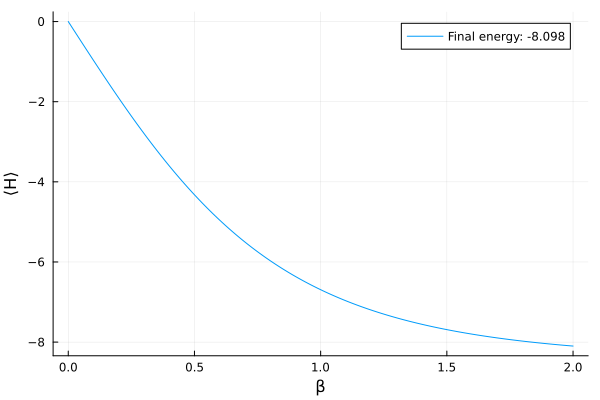

In [8]:
using Plots

betas = LinRange(0, beta, length(energies))

plot(betas, energies, xlabel="β", ylabel="⟨H⟩", label="Final energy: $(round(energies[end], digits=3))")

A few final notes on imaginary time: 
- `ImaginaryPauliRotation`s are currently not supported in the Heisenberg picture. Feel free to work around it to experiment.
- Because lower temperature states are so drastically denser in Pauli basis, the betas (temperatures) reachable may be very low (high) at higher qubit numbers.
- Truncations are both your friend and enemy - as always. They make things faster until they make them wrong.
- Be mindful of the normalization performed in the propagation. It continually divides through by the partition sum.